In [35]:
import os

import random
from collections import defaultdict

from io import open

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import SmoothL1Loss
from torch import optim

import torch.nn.functional as F

import csv

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [36]:
print(f"{os.getcwd()}")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

D:\workspace\ai_study\projects\fault_predict


In [37]:
# 数据预处理
# 数据预处理策略：将原数据集orig_data.csv按一定比例拆分成2部分：训练集和测试集。然后将训练集或测试集的样本按如下方式形成一个个样本及标签：
# 假设原数据集样本 a1、a2、a3、a4、...、a10、a11、a12，则形成新的样本集合：
# 样本1：a1、a2、a3、a4、...、a10, 标签为a11
# 样本2：a2、a3、a4、a5、...、a11，标签为a12，以此类推。

project_root = "D:\\workspace\\ai_study\\projects\\fault_predict"
dataset_root = "D:\\workspace\\ai_study\\projects\\fault_predict\\data"

orig_file = os.path.join(dataset_root, "orig_data.csv")
meta_file = os.path.join(dataset_root, "meta.csv")

train_dataset_dir = os.path.join(dataset_root, "train")
test_dataset_dir = os.path.join(dataset_root, "test")

train_data_file = os.path.join(train_dataset_dir, "train.csv")
test_data_file = os.path.join(test_dataset_dir, "test.csv")

train_data_ratio = 0.8
feature_count = 10

label_multiplier = 1e10

def make_dirs_if_necessary(path):
    if not os.path.exists(path=path):
        print(f"创建目录 {path}")
        os.makedirs(name=path)

def predeal_data(src_file, train_file, test_file, train_data_ratio, feature_count):
    if not os.path.exists(src_file):
        raise(f"{src_file} 不存在！")
    
    header = None
    orig_data = []
    with open(file=orig_file, mode="r", encoding="utf8") as tmp_csv_file:
        # 读表头
        raw_line = tmp_csv_file.readline()
        if len(raw_line) <= 0:
            raise(f"{src_file} 格式不符合要求，需有表头字段data！")

        if header is None:
            header = raw_line.strip().split(",")
                        
        while True:
            raw_line = tmp_csv_file.readline()
            if len(raw_line) <= 0:
                break
            
            orig_data.append(float(raw_line.strip()))
   
    data_count = len(orig_data)
    if data_count <= 0:
        raise(f"{src_file} 未读取到数据！")
        
    if data_count == 1:
        train_data_count = 1
        test_data_count = 0
    else:
        train_data_count = int(data_count * train_data_ratio)
        test_data_count = data_count - train_data_count
        if test_data_count <= 0:
            test_data_count = 1
            train_data_count = data_count - test_data_count
            
    print(f"训练数据：{train_data_count}, 测试数据：{test_data_count}, 总数据：{data_count}")
    
    generate_data(data_file=train_file, data=orig_data[:train_data_count], feature_count=feature_count)
    generate_data(data_file=test_file, data=orig_data[train_data_count:], feature_count=feature_count)
    
    generate_meta_data(data_file=meta_file, feature_count=feature_count, train_count=train_data_count, test_count=test_data_count)
    
def generate_meta_data(data_file, feature_count, train_count, test_count):
    headers = ["feature_count", "train_count", "test_count"]
    with open(file=data_file, mode="w", encoding="utf8", newline='') as csv_file:
        csv_writer = csv.DictWriter(f=csv_file, fieldnames=headers)
        csv_writer.writeheader()
        
        new_row = defaultdict()
        new_row[headers[0]] = feature_count
        new_row[headers[1]] = train_count
        new_row[headers[2]] = test_count
        
        csv_writer.writerow(new_row)
        
        print("导出 " + data_file + " 成功")
    
        
def generate_data(data_file, data, feature_count):
    headers = []
    for i in range(feature_count):
        headers.append("Feature" + str(i))
    headers.append("Target")
    
    with open(file=data_file, mode="w", encoding="utf8", newline='') as csv_file:
        csv_writer = csv.DictWriter(f=csv_file, fieldnames=headers)
        csv_writer.writeheader()
        
        data_count = len(data)
        cur_index = 0
        
        while cur_index + feature_count <= data_count - 1:
            new_row = defaultdict()
            for i in range(len(headers)):
                new_row[headers[i]] = data[cur_index + i]
                            
            csv_writer.writerow(new_row)
                            
            cur_index += 1
        
        
        print("导出 " + data_file + " 成功")

# 如果需要重新生成数据，再打开注释、修改参数再执行
# make_dirs_if_necessary(path=train_dataset_dir)
# make_dirs_if_necessary(path=test_dataset_dir)

# predeal_data(src_file=orig_file,
#              train_file=train_data_file,
#              test_file=test_data_file,
#              train_data_ratio=train_data_ratio,
#              feature_count=feature_count)

In [46]:
# 定义数据集
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class MyDataset(Dataset):
    """
    从全量样本，随机选取一部分数据作为某次迭代的样本集合，选取的数据量可配置。
    """
    def __init__(self, meta_file, data_file, data_count, train_flag=True):
        super(MyDataset, self).__init__()
        self.meta_file = meta_file
        self.data_file = data_file
        
        self.data = []
        self.labels = []
        
        self.data_count = data_count

        self.train_flag=train_flag
        
        self._read()
    
    def _read(self):
        with open(file=self.meta_file, mode="r", encoding="utf8") as f:
            while True:
                # ignore header
                f.readline()
                line = f.readline().strip()
                if len(line) <= 0:
                    break
                    
                line = line.split(",")
                
                self.feature_count = int(line[0])
                self.train_count = int(line[1])
                self.test_count = int(line[2])
                
    def reset_dataset(self):
        """
        重新从数据集中，随机选取一部分数据作为样本。
        """
        self.data.clear()
        self.labels.clear()
        
        total_sample_count = self.train_count if self.train_flag else self.test_count
        total_sample_idx = list(range(total_sample_count))
        sample_data_idx = [random.choice(total_sample_idx) for i in range(self.data_count)]

#         print(f"select idx: {sample_data_idx}")
        
        with open(file=self.data_file, mode="r", encoding="utf8") as f:
            # ignore header
            f.readline()
            item_idx = -1
            
            while True:
                line = f.readline().strip()
                if len(line) <= 0:
                    break

                item_idx += 1
                if item_idx not in sample_data_idx:
                    continue
                    
                line_items = line.split(",")
                data_item = []
                for item in line_items[:-1]:
                    data_item.append(float(item))
                    
                self.data.append(data_item)
                self.labels.append(float(line_items[-1]))

#         print(f"重置数据集成功，data:{len(self.data)}, labels:{len(self.labels)}")

    def __getitem__(self, idx):
        return torch.FloatTensor(self.data[idx]), torch.tensor(int(self.labels[idx] * label_multiplier), dtype=torch.long)

    def __len__(self):
        return len(self.data)
    
    @staticmethod
    def collate_fn(batch):
        data, labels = tuple(zip(*batch))
        return data, labels
    

In [47]:
# 定义Seq2Seq
# Encoder
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size

        self.gru = nn.GRU(input_size, hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout), bidirectional=True)

    def forward(self, input_seq, hidden=None):
        # Forward pass through GRU
        outputs, hidden = self.gru(input_seq, hidden)
        # Sum bidirectional GRU outputs
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        # Return output and final hidden state
        return outputs, hidden

# Attention 
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(hidden_size))

    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)

    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)
        return torch.sum(hidden * energy, dim=2)

    def concat_score(self, hidden, encoder_output):
        energy = self.attn(torch.cat((hidden.expand(encoder_output.size(0), -1, -1), encoder_output), 2)).tanh()
        return torch.sum(self.v * energy, dim=2)

    def forward(self, hidden, encoder_outputs):
        # Calculate the attention weights (energies) based on the given method
        if self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        elif self.method == 'dot':
            attn_energies = self.dot_score(hidden, encoder_outputs)

        # Transpose max_length and batch_size dimensions
        attn_energies = attn_energies.t()

        # Return the softmax normalized probability scores (with added dimension)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)

# Decoder
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, hidden_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        # Keep for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout

        # Define layers
        self.gru = nn.GRU(1, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, 1)

        self.attn = Attn(attn_model, hidden_size)

    def forward(self, decoder_input, last_hidden, encoder_outputs):
        # Forward through unidirectional GRU
        # [1, B, hidden_size], [num_layers, B, hidden_size]->[1, B, hidden_size], [num_layers, B, hidden_size]
        rnn_output, hidden = self.gru(decoder_input, last_hidden)
        # Calculate attention weights from the current GRU output [64,1,10] * [64,10,500]=[64,1,500]
        # [1, B, hidden_size], [T, B, hidden_size]->[B, 1, T]
        attn_weights = self.attn(rnn_output, encoder_outputs)
        # Multiply attention weights to encoder outputs to get new "weighted sum" context vector
        # [B, 1, T], [B, T, hidden_size]->[B, 1, hidden_size]
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        # Concatenate weighted context vector and GRU output using Luong eq. 5
        # [1, B, hidden_size]->[B, hidden_size]
        rnn_output = rnn_output.squeeze(0)
        # [B, 1, hidden_size]->[B, hidden_size]
        context = context.squeeze(1)
        # [B, hidden_size], [B, hidden_size]->[B, 2 * hidden_size]
        concat_input = torch.cat((rnn_output, context), dim=1)
        # [B, 2 * hidden_size]->[B, hidden_size]
        concat_output = torch.tanh(self.concat(concat_input))
        # Predict next word using Luong eq. 6
        # [B, hidden_size]->[B, num_words]
        output = self.out(concat_output)
        # Return output and final hidden state
        # [B, 1], [num_layers, B, hidden_size]
        return output, hidden


In [48]:
# 定义训练过程
def train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, batch_size, clip):
    # Zero gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Set device options
    input_variable = input_variable.to(device)
    input_variable = input_variable.permute(1, 0)
    input_variable = input_variable.unsqueeze(dim=2)
    target_variable = target_variable.to(device)

    # Forward pass through encoder
    # [T, B, hidden_size] -> [T, B, hidden_size], [num_directions * num_layers, B, hidden_size]
    encoder_outputs, encoder_hidden = encoder(input_variable)

    # Set initial decoder hidden state to the encoder's final hidden state
    # [num_directions * num_layers, B, hidden_size] -> [num_layers, B, hidden_size]
    decoder_hidden = encoder_hidden[:decoder.n_layers]

    # Determine if we are using teacher forcing this iteration
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    # Forward batch of sequences through decoder one time step at a time
    if use_teacher_forcing:
        # Teacher forcing: next input is current target
        # [B] -> [1, B]
        decoder_input = target_variable.view(1, -1)
        decoder_input = decoder_input.unsqueeze(dim=2)
        # [1, B], [num_layers, B, hidden_size], [T, B, hidden_size]->[B, 1], [num_layers, B, hidden_size]
        decoder_output, decoder_hidden = decoder(
            decoder_input, decoder_hidden, encoder_outputs
        )
        
        # Calculate loss
        # [B, 1], [B]-> Float
        cur_loss = compute_loss(decoder_output, target_variable)
    else:
        # Create initial decoder input (start with SOS tokens for each sentence)
        # [1, B]
        decoder_input = torch.tensor([[SOS_token for _ in range(batch_size)]], dtype=torch.float32)
        decoder_input = decoder_input.to(device)
        decoder_input = decoder_input.unsqueeze(dim=2)
        
        decoder_output, decoder_hidden = decoder(
            decoder_input, decoder_hidden, encoder_outputs
        )
        # Calculate loss
        # [B, 1], [B]->Float
        cur_loss = compute_loss(decoder_output, target_variable)

    # Perform backpropatation
    cur_loss.backward()

    # Clip gradients: gradients are modified in place
    _ = nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    # Adjust model weights
    encoder_optimizer.step()
    decoder_optimizer.step()

    return cur_loss

# 定义测试过程
def test(input_variable, target_variable, encoder, decoder, batch_size):
    # Set device options
    input_variable = input_variable.to(device)
    input_variable = input_variable.permute(1, 0)
    input_variable = input_variable.unsqueeze(dim=2)
    target_variable = target_variable.to(device)

    # Forward pass through encoder
    # [T, B, hidden_size] -> [T, B, hidden_size], [num_directions * num_layers, B, hidden_size]
    encoder_outputs, encoder_hidden = encoder(input_variable)

    # Set initial decoder hidden state to the encoder's final hidden state
    # [num_directions * num_layers, B, hidden_size] -> [num_layers, B, hidden_size]
    decoder_hidden = encoder_hidden[:decoder.n_layers]

    # Create initial decoder input (start with SOS tokens for each sentence)
    # [1, B]
    decoder_input = torch.tensor([[SOS_token for _ in range(batch_size)]], dtype=torch.float32)
    decoder_input = decoder_input.to(device)
    decoder_input = decoder_input.unsqueeze(dim=2)

    decoder_output, decoder_hidden = decoder(
        decoder_input, decoder_hidden, encoder_outputs
    )

    # Calculate loss
    # [B, 1], [B]->Float
    loss = compute_loss(decoder_output, target_variable)
    return decoder_output.detach().numpy(), target_variable.detach().numpy(), loss

def draw_test_result(decoder_output, target_variable):
    plt.figure(figsize=(7, 4))

    x = np.arange(len(decoder_output))
    plt.plot(x, decoder_output, label="Predict", c="b", marker="+", alpha=0.7)
    plt.plot(x, target_variable, label="Actual", c="r", marker="*", alpha=0.7)

    plt.xlabel("Time Series")
    plt.ylabel("Oscillation Amplitude")

    plt.title("Predict effect of Oscillation Amplitude on Test Dataset")

    plt.show()

def compute_loss(predict, target):
    lossfn = SmoothL1Loss()
    # [B], [B]-> Float
    loss = lossfn(predict.view(-1), target)
    loss = loss.to(device)
    return loss

def trainIters(model_name, encoder, decoder, encoder_optimizer, decoder_optimizer, encoder_n_layers, 
               decoder_n_layers, save_dir, n_iteration, batch_size, print_every, save_every, clip,
               loadFilename, train_dataset, test_dataset):
    # Initializations
    print('Initializing ...')
    start_iteration = 1
    print_loss = 0
    if loadFilename:
        start_iteration = checkpoint['iteration'] + 1

    # Training loop
    print("Training...")
    for iteration in range(start_iteration, n_iteration + 1):
        train_dataset.reset_dataset()
        train_dataloader = DataLoader(dataset=train_dataset,
                                      collate_fn=train_dataset.collate_fn,
                                      shuffle=True, 
    #                                   num_workers=nw,
                                      drop_last=True,
                                      batch_size=batch_size)
        
        for i, (data, targets) in enumerate(train_dataloader):
            data = torch.stack(tensors=data)
            data = data.to(device=device)
            
            targets = torch.stack(tensors=targets)
            targets = targets.to(dtype=torch.float32).to(device=device)
            targets /= label_multiplier

            # Run a training iteration with batch
            loss = train(input_variable=data,
                         target_variable=targets,
                         encoder=encoder,
                         decoder=decoder,
                         encoder_optimizer=encoder_optimizer,
                         decoder_optimizer=decoder_optimizer,
                         batch_size=batch_size,
                         clip=clip)
            print_loss += loss

        # Print progress
        if iteration % print_every == 0:
            train_batch_count = len(train_dataset) // batch_size
            train_loss_avg = print_loss / print_every / train_batch_count
            print(f"Iteration: {iteration}/[{i}/{train_batch_count}]; Percent complete: {iteration/ n_iteration * 100:.1f}%; Average loss: {train_loss_avg:.4f}")
            print_loss = 0

            # 测试集验证
            test_dataset.reset_dataset()
            test_dataloader = DataLoader(dataset=test_dataset,
                                         collate_fn=test_dataset.collate_fn,
                                         shuffle=True,
                                         # num_workers=nw,
                                         drop_last=True,
                                         batch_size=batch_size)

            test_loss = 0
            test_batch_count = len(test_dataset) // batch_size
            predict_values = np.array([])
            target_values = np.array([])
            for i, (data, targets) in enumerate(test_dataloader):
                data = torch.stack(tensors=data)
                data = data.to(device=device)

                targets = torch.stack(tensors=targets)
                targets = targets.to(dtype=torch.float32).to(device=device)
                targets /= label_multiplier

                predict_value, target_value, loss = test(input_variable=data,
                                                         target_variable=targets,
                                                         encoder=encoder,
                                                         decoder=decoder,
                                                         batch_size=batch_size)
                test_loss += loss
                predict_values = np.append(predict_values, predict_value)
                target_values = np.append(target_values, target_value)

            if iteration % save_every == 0:
                draw_test_result(predict_values, target_values)
            print(f"Iteration: {iteration}; Test Average loss: {test_loss / test_batch_count:.4f}")

        # Save checkpoint
        if (iteration % save_every == 0):
            directory = os.path.join(save_dir, model_name, '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size))
            if not os.path.exists(directory):
                os.makedirs(directory)
            torch.save({
                'iteration': iteration,
                'en': encoder.state_dict(),
                'de': decoder.state_dict(),
                'en_opt': encoder_optimizer.state_dict(),
                'de_opt': decoder_optimizer.state_dict(),
                'loss': loss
            }, os.path.join(directory, '{}_{}.tar'.format(iteration, 'checkpoint')))

Building encoder and decoder ...
Models built and ready to go!
Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 1/[29/30]; Percent complete: 1.0%; Average loss: 0.0037
Iteration: 1; Test Average loss: 0.0027
Iteration: 2/[29/30]; Percent complete: 2.0%; Average loss: 0.0025
Iteration: 2; Test Average loss: 0.0024
Iteration: 3/[29/30]; Percent complete: 3.0%; Average loss: 0.0019
Iteration: 3; Test Average loss: 0.0015
Iteration: 4/[29/30]; Percent complete: 4.0%; Average loss: 0.0011
Iteration: 4; Test Average loss: 0.0006
Iteration: 5/[29/30]; Percent complete: 5.0%; Average loss: 0.0005


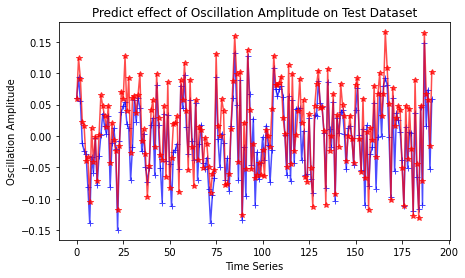

Iteration: 5; Test Average loss: 0.0005
Iteration: 6/[29/30]; Percent complete: 6.0%; Average loss: 0.0007
Iteration: 6; Test Average loss: 0.0007
Iteration: 7/[29/30]; Percent complete: 7.0%; Average loss: 0.0007
Iteration: 7; Test Average loss: 0.0006
Iteration: 8/[29/30]; Percent complete: 8.0%; Average loss: 0.0003
Iteration: 8; Test Average loss: 0.0003
Iteration: 9/[29/30]; Percent complete: 9.0%; Average loss: 0.0003
Iteration: 9; Test Average loss: 0.0003
Iteration: 10/[29/30]; Percent complete: 10.0%; Average loss: 0.0003


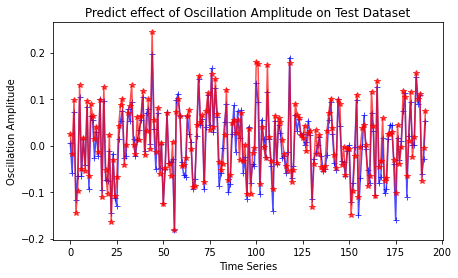

Iteration: 10; Test Average loss: 0.0003
Iteration: 11/[29/30]; Percent complete: 11.0%; Average loss: 0.0003
Iteration: 11; Test Average loss: 0.0003
Iteration: 12/[29/30]; Percent complete: 12.0%; Average loss: 0.0003
Iteration: 12; Test Average loss: 0.0002
Iteration: 13/[29/30]; Percent complete: 13.0%; Average loss: 0.0002
Iteration: 13; Test Average loss: 0.0002
Iteration: 14/[29/30]; Percent complete: 14.0%; Average loss: 0.0002
Iteration: 14; Test Average loss: 0.0002
Iteration: 15/[29/30]; Percent complete: 15.0%; Average loss: 0.0002


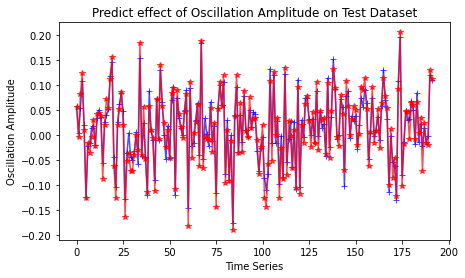

Iteration: 15; Test Average loss: 0.0002
Iteration: 16/[29/30]; Percent complete: 16.0%; Average loss: 0.0002
Iteration: 16; Test Average loss: 0.0003
Iteration: 17/[29/30]; Percent complete: 17.0%; Average loss: 0.0005
Iteration: 17; Test Average loss: 0.0003
Iteration: 18/[29/30]; Percent complete: 18.0%; Average loss: 0.0003
Iteration: 18; Test Average loss: 0.0002
Iteration: 19/[29/30]; Percent complete: 19.0%; Average loss: 0.0002
Iteration: 19; Test Average loss: 0.0002
Iteration: 20/[29/30]; Percent complete: 20.0%; Average loss: 0.0002


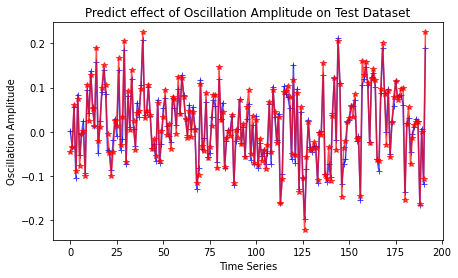

Iteration: 20; Test Average loss: 0.0001
Iteration: 21/[29/30]; Percent complete: 21.0%; Average loss: 0.0002
Iteration: 21; Test Average loss: 0.0002
Iteration: 22/[29/30]; Percent complete: 22.0%; Average loss: 0.0002
Iteration: 22; Test Average loss: 0.0001
Iteration: 23/[29/30]; Percent complete: 23.0%; Average loss: 0.0001
Iteration: 23; Test Average loss: 0.0002
Iteration: 24/[29/30]; Percent complete: 24.0%; Average loss: 0.0001
Iteration: 24; Test Average loss: 0.0001
Iteration: 25/[29/30]; Percent complete: 25.0%; Average loss: 0.0001


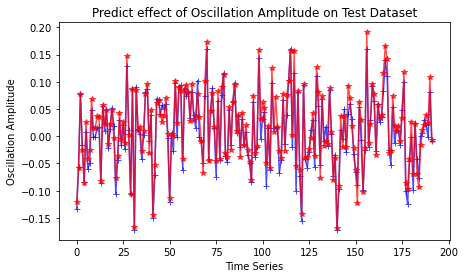

Iteration: 25; Test Average loss: 0.0002
Iteration: 26/[29/30]; Percent complete: 26.0%; Average loss: 0.0001
Iteration: 26; Test Average loss: 0.0001
Iteration: 27/[29/30]; Percent complete: 27.0%; Average loss: 0.0001
Iteration: 27; Test Average loss: 0.0002
Iteration: 28/[29/30]; Percent complete: 28.0%; Average loss: 0.0001
Iteration: 28; Test Average loss: 0.0002
Iteration: 29/[29/30]; Percent complete: 29.0%; Average loss: 0.0001
Iteration: 29; Test Average loss: 0.0003
Iteration: 30/[29/30]; Percent complete: 30.0%; Average loss: 0.0003


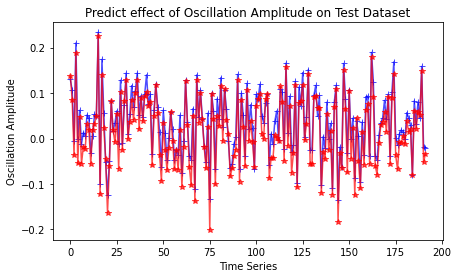

Iteration: 30; Test Average loss: 0.0003
Iteration: 31/[29/30]; Percent complete: 31.0%; Average loss: 0.0002
Iteration: 31; Test Average loss: 0.0001
Iteration: 32/[29/30]; Percent complete: 32.0%; Average loss: 0.0001
Iteration: 32; Test Average loss: 0.0001
Iteration: 33/[29/30]; Percent complete: 33.0%; Average loss: 0.0001
Iteration: 33; Test Average loss: 0.0001
Iteration: 34/[29/30]; Percent complete: 34.0%; Average loss: 0.0001
Iteration: 34; Test Average loss: 0.0001
Iteration: 35/[29/30]; Percent complete: 35.0%; Average loss: 0.0001


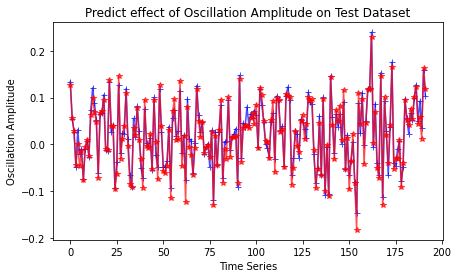

Iteration: 35; Test Average loss: 0.0001
Iteration: 36/[29/30]; Percent complete: 36.0%; Average loss: 0.0001
Iteration: 36; Test Average loss: 0.0001
Iteration: 37/[29/30]; Percent complete: 37.0%; Average loss: 0.0001
Iteration: 37; Test Average loss: 0.0001
Iteration: 38/[29/30]; Percent complete: 38.0%; Average loss: 0.0001
Iteration: 38; Test Average loss: 0.0001
Iteration: 39/[29/30]; Percent complete: 39.0%; Average loss: 0.0001
Iteration: 39; Test Average loss: 0.0001
Iteration: 40/[29/30]; Percent complete: 40.0%; Average loss: 0.0001


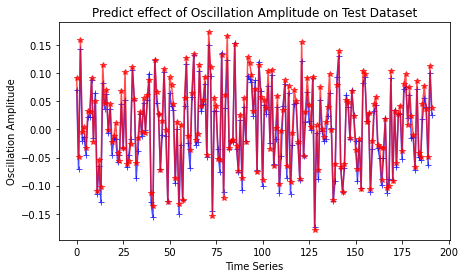

Iteration: 40; Test Average loss: 0.0001
Iteration: 41/[29/30]; Percent complete: 41.0%; Average loss: 0.0001
Iteration: 41; Test Average loss: 0.0001
Iteration: 42/[29/30]; Percent complete: 42.0%; Average loss: 0.0001
Iteration: 42; Test Average loss: 0.0001
Iteration: 43/[29/30]; Percent complete: 43.0%; Average loss: 0.0001
Iteration: 43; Test Average loss: 0.0001
Iteration: 44/[29/30]; Percent complete: 44.0%; Average loss: 0.0001
Iteration: 44; Test Average loss: 0.0001
Iteration: 45/[29/30]; Percent complete: 45.0%; Average loss: 0.0001


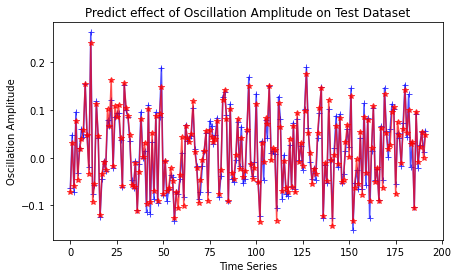

Iteration: 45; Test Average loss: 0.0001
Iteration: 46/[29/30]; Percent complete: 46.0%; Average loss: 0.0001
Iteration: 46; Test Average loss: 0.0001
Iteration: 47/[29/30]; Percent complete: 47.0%; Average loss: 0.0001
Iteration: 47; Test Average loss: 0.0001
Iteration: 48/[29/30]; Percent complete: 48.0%; Average loss: 0.0001
Iteration: 48; Test Average loss: 0.0001
Iteration: 49/[29/30]; Percent complete: 49.0%; Average loss: 0.0001
Iteration: 49; Test Average loss: 0.0001
Iteration: 50/[29/30]; Percent complete: 50.0%; Average loss: 0.0001


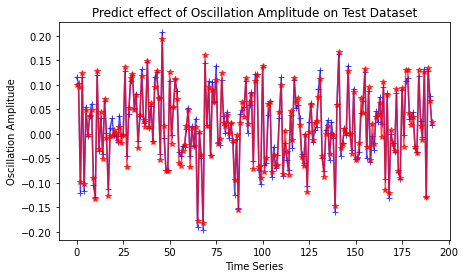

Iteration: 50; Test Average loss: 0.0001
Iteration: 51/[29/30]; Percent complete: 51.0%; Average loss: 0.0001
Iteration: 51; Test Average loss: 0.0001
Iteration: 52/[29/30]; Percent complete: 52.0%; Average loss: 0.0001
Iteration: 52; Test Average loss: 0.0001
Iteration: 53/[29/30]; Percent complete: 53.0%; Average loss: 0.0001
Iteration: 53; Test Average loss: 0.0001
Iteration: 54/[29/30]; Percent complete: 54.0%; Average loss: 0.0001
Iteration: 54; Test Average loss: 0.0001
Iteration: 55/[29/30]; Percent complete: 55.0%; Average loss: 0.0001


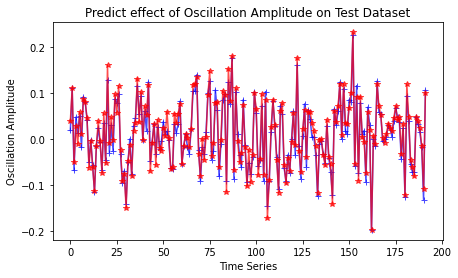

Iteration: 55; Test Average loss: 0.0001
Iteration: 56/[29/30]; Percent complete: 56.0%; Average loss: 0.0001
Iteration: 56; Test Average loss: 0.0001
Iteration: 57/[29/30]; Percent complete: 57.0%; Average loss: 0.0001
Iteration: 57; Test Average loss: 0.0001
Iteration: 58/[29/30]; Percent complete: 58.0%; Average loss: 0.0001
Iteration: 58; Test Average loss: 0.0001
Iteration: 59/[29/30]; Percent complete: 59.0%; Average loss: 0.0001
Iteration: 59; Test Average loss: 0.0001
Iteration: 60/[29/30]; Percent complete: 60.0%; Average loss: 0.0001


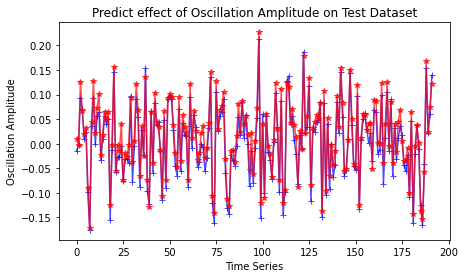

Iteration: 60; Test Average loss: 0.0002
Iteration: 61/[29/30]; Percent complete: 61.0%; Average loss: 0.0001
Iteration: 61; Test Average loss: 0.0001
Iteration: 62/[29/30]; Percent complete: 62.0%; Average loss: 0.0001
Iteration: 62; Test Average loss: 0.0002
Iteration: 63/[29/30]; Percent complete: 63.0%; Average loss: 0.0001
Iteration: 63; Test Average loss: 0.0001
Iteration: 64/[29/30]; Percent complete: 64.0%; Average loss: 0.0001
Iteration: 64; Test Average loss: 0.0001
Iteration: 65/[29/30]; Percent complete: 65.0%; Average loss: 0.0001


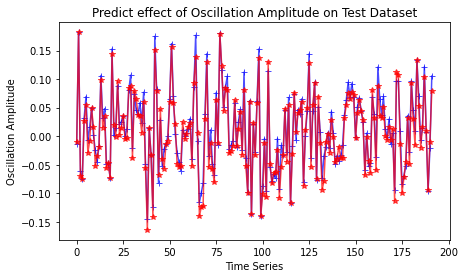

Iteration: 65; Test Average loss: 0.0001
Iteration: 66/[29/30]; Percent complete: 66.0%; Average loss: 0.0001
Iteration: 66; Test Average loss: 0.0001
Iteration: 67/[29/30]; Percent complete: 67.0%; Average loss: 0.0001
Iteration: 67; Test Average loss: 0.0001
Iteration: 68/[29/30]; Percent complete: 68.0%; Average loss: 0.0001
Iteration: 68; Test Average loss: 0.0001
Iteration: 69/[29/30]; Percent complete: 69.0%; Average loss: 0.0001
Iteration: 69; Test Average loss: 0.0001
Iteration: 70/[29/30]; Percent complete: 70.0%; Average loss: 0.0001


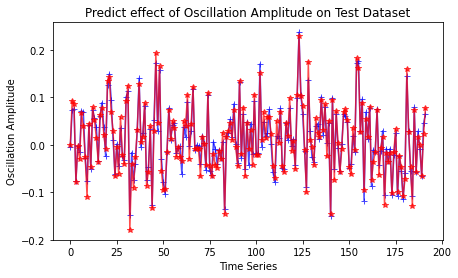

Iteration: 70; Test Average loss: 0.0001
Iteration: 71/[29/30]; Percent complete: 71.0%; Average loss: 0.0001
Iteration: 71; Test Average loss: 0.0001
Iteration: 72/[29/30]; Percent complete: 72.0%; Average loss: 0.0001
Iteration: 72; Test Average loss: 0.0001
Iteration: 73/[29/30]; Percent complete: 73.0%; Average loss: 0.0001
Iteration: 73; Test Average loss: 0.0001
Iteration: 74/[29/30]; Percent complete: 74.0%; Average loss: 0.0001
Iteration: 74; Test Average loss: 0.0001
Iteration: 75/[29/30]; Percent complete: 75.0%; Average loss: 0.0001


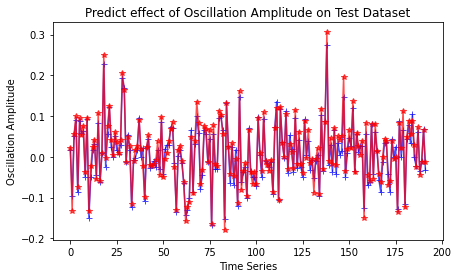

Iteration: 75; Test Average loss: 0.0001
Iteration: 76/[29/30]; Percent complete: 76.0%; Average loss: 0.0001
Iteration: 76; Test Average loss: 0.0001
Iteration: 77/[29/30]; Percent complete: 77.0%; Average loss: 0.0001
Iteration: 77; Test Average loss: 0.0001
Iteration: 78/[29/30]; Percent complete: 78.0%; Average loss: 0.0001
Iteration: 78; Test Average loss: 0.0001
Iteration: 79/[29/30]; Percent complete: 79.0%; Average loss: 0.0001
Iteration: 79; Test Average loss: 0.0001
Iteration: 80/[29/30]; Percent complete: 80.0%; Average loss: 0.0001


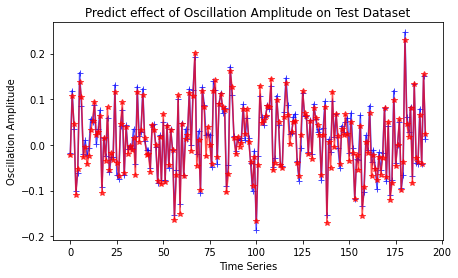

Iteration: 80; Test Average loss: 0.0001
Iteration: 81/[29/30]; Percent complete: 81.0%; Average loss: 0.0001
Iteration: 81; Test Average loss: 0.0001
Iteration: 82/[29/30]; Percent complete: 82.0%; Average loss: 0.0001
Iteration: 82; Test Average loss: 0.0001
Iteration: 83/[29/30]; Percent complete: 83.0%; Average loss: 0.0001
Iteration: 83; Test Average loss: 0.0001
Iteration: 84/[29/30]; Percent complete: 84.0%; Average loss: 0.0001
Iteration: 84; Test Average loss: 0.0001
Iteration: 85/[29/30]; Percent complete: 85.0%; Average loss: 0.0001


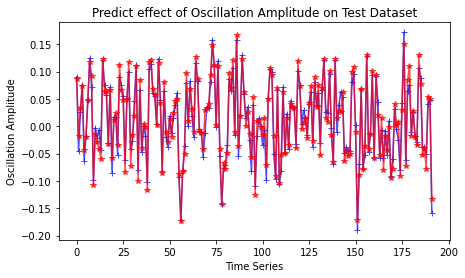

Iteration: 85; Test Average loss: 0.0001
Iteration: 86/[29/30]; Percent complete: 86.0%; Average loss: 0.0001
Iteration: 86; Test Average loss: 0.0001
Iteration: 87/[29/30]; Percent complete: 87.0%; Average loss: 0.0001
Iteration: 87; Test Average loss: 0.0001
Iteration: 88/[29/30]; Percent complete: 88.0%; Average loss: 0.0001
Iteration: 88; Test Average loss: 0.0001
Iteration: 89/[29/30]; Percent complete: 89.0%; Average loss: 0.0001
Iteration: 89; Test Average loss: 0.0001
Iteration: 90/[29/30]; Percent complete: 90.0%; Average loss: 0.0001


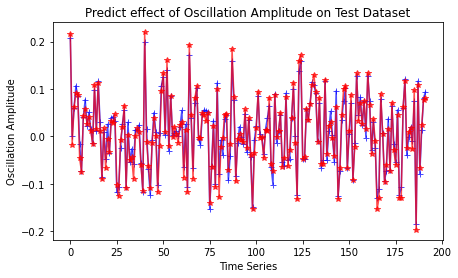

Iteration: 90; Test Average loss: 0.0001
Iteration: 91/[29/30]; Percent complete: 91.0%; Average loss: 0.0001
Iteration: 91; Test Average loss: 0.0001
Iteration: 92/[29/30]; Percent complete: 92.0%; Average loss: 0.0001
Iteration: 92; Test Average loss: 0.0001
Iteration: 93/[29/30]; Percent complete: 93.0%; Average loss: 0.0001
Iteration: 93; Test Average loss: 0.0001
Iteration: 94/[29/30]; Percent complete: 94.0%; Average loss: 0.0001
Iteration: 94; Test Average loss: 0.0001
Iteration: 95/[29/30]; Percent complete: 95.0%; Average loss: 0.0001


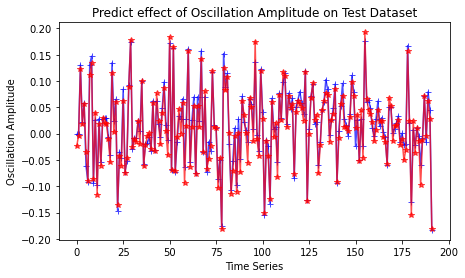

Iteration: 95; Test Average loss: 0.0001
Iteration: 96/[29/30]; Percent complete: 96.0%; Average loss: 0.0001
Iteration: 96; Test Average loss: 0.0001
Iteration: 97/[29/30]; Percent complete: 97.0%; Average loss: 0.0001
Iteration: 97; Test Average loss: 0.0001
Iteration: 98/[29/30]; Percent complete: 98.0%; Average loss: 0.0001
Iteration: 98; Test Average loss: 0.0001
Iteration: 99/[29/30]; Percent complete: 99.0%; Average loss: 0.0001
Iteration: 99; Test Average loss: 0.0001
Iteration: 100/[29/30]; Percent complete: 100.0%; Average loss: 0.0001


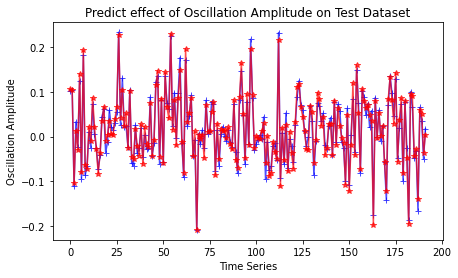

Iteration: 100; Test Average loss: 0.0001


In [49]:
def start_train():
    # checkpoint_iter = 4000
    # loadFilename = os.path.join(save_dir, model_name, corpus_name,
    #                            '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size),
    #                            '{}_checkpoint.tar'.format(checkpoint_iter))


    # Load model if a loadFilename is provided
    if loadFilename:
        # If loading on same machine the model was trained on
        checkpoint = torch.load(loadFilename)
        # If loading a model trained on GPU to CPU
        #checkpoint = torch.load(loadFilename, map_location=torch.device('cpu'))
        encoder_sd = checkpoint['en']
        decoder_sd = checkpoint['de']
        encoder_optimizer_sd = checkpoint['en_opt']
        decoder_optimizer_sd = checkpoint['de_opt']

    print('Building encoder and decoder ...')

    # Initialize encoder & decoder models
    encoder = EncoderRNN(input_size=1,
                         hidden_size=hidden_size,
                         n_layers=encoder_n_layers,
                         dropout=dropout)
    decoder = LuongAttnDecoderRNN(attn_model, hidden_size, decoder_n_layers, dropout)
    if loadFilename:
        encoder.load_state_dict(encoder_sd)
        decoder.load_state_dict(decoder_sd)
    # Use appropriate device
    encoder = encoder.to(device)
    decoder = decoder.to(device)

    print('Models built and ready to go!')

    # Ensure dropout layers are in train mode
    encoder.train()
    decoder.train()

    # Initialize optimizers
    print('Building optimizers ...')
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
    if loadFilename:
        encoder_optimizer.load_state_dict(encoder_optimizer_sd)
        decoder_optimizer.load_state_dict(decoder_optimizer_sd)

    # If you have cuda, configure cuda to call
    for state in encoder_optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.cuda()

    for state in decoder_optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.cuda()

    # Run training iterations
    print("Starting Training!")

    # 定义训练集
    train_dataset = MyDataset(meta_file=meta_file,
                              data_file=train_data_file,
                              data_count=train_data_count,
                              train_flag=True)
    # 定义测试集
    test_dataset = MyDataset(meta_file=meta_file,
                             data_file=test_data_file,
                             data_count=test_data_count,
                             train_flag=False)

    trainIters(model_name=model_name,
               encoder=encoder,
               decoder=decoder,
               encoder_optimizer=encoder_optimizer,
               decoder_optimizer=decoder_optimizer,
               encoder_n_layers=encoder_n_layers,
               decoder_n_layers=decoder_n_layers,
               save_dir=save_dir,
               n_iteration=n_iteration,
               batch_size=batch_size,
               print_every=print_every,
               save_every=save_every,
               clip=clip,
               loadFilename=loadFilename,
               train_dataset=train_dataset,
               test_dataset=test_dataset)


# Configure model train global params
model_name = 'fault_predict_model'
attn_model = 'dot'
hidden_size = 512
encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.1
batch_size = 64

# Configure training/optimization
clip = 50.0
teacher_forcing_ratio = .5
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iteration = 100
print_every = 1
save_every = 5

train_data_count = 2000
test_data_count = 200

SOS_token = 1  # Start token

save_dir = os.path.join(project_root, "save")

# Set checkpoint to load from; set to None if starting from scratch
loadFilename = None
checkpoint = None

# 进入训练模式
start_train()



Models built and ready to go!


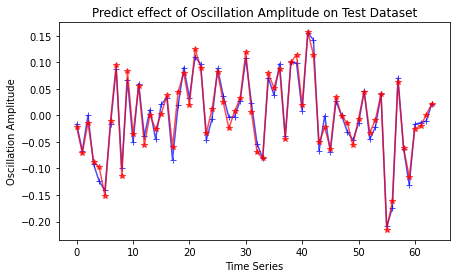

In [50]:
# 进入评估模式
def start_eval():
    # 测试数据手动采样于test.csv，采样策略是打乱次序和任意抽取，每两个样本不一定相邻，甚至后面的样本在test.csv中的位置还靠前。
    inputs = [
        [-0.023573538, -0.009387692,  0.003963692,  0.023990769,  0.010430769,  0.018358154,  0.045269538,  0.057369231,  0.066131077,  0.024825231],
        [ 0.043183385,  0.084489231,  0.115155692,  0.120788308,  0.060498462,  0.008344615, -0.042557538, -0.077187692, -0.071346462, -0.080525538],
        [ 0.032752615,  0.053614154,  0.070929231,  0.083446154,  0.065296615,  0.018566769, -0.040888615, -0.081985846, -0.0678,      -0.036299077],
        [ 0.036507692,  0.04068,      0.001251692, -0.042974769, -0.071137846, -0.071555077, -0.075101538, -0.089078769, -0.095545846, -0.111192],
        [-0.180660923, -0.182329846, -0.180243692, -0.1356,      -0.113695385, -0.078022154, -0.047772923, -0.019192615, -0.002086154, -0.056952],

        [-0.056952,    -0.033795692,  0.006675692,  0.018984,    -0.003755077, -0.049233231, -0.087827077, -0.110357538, -0.127881231, -0.140606769],
        [-0.042140308, -0.019818462,  0.006258462,  0.050484923,  0.063836308,  0.041514462, -0.009179077, -0.060498462, -0.066131077, -0.042974769],
        [0.053822769,  -0.000834462, -0.017940923, -0.003129231,  0.027328615,  0.042557538,  0.030666462,  0.037759385,  0.055491692,  0.081777231],
        [-0.022113231,  0.015228923,  0.021487385, -0.009804923, -0.012308308,  0.007718769,  0.014603077, -0.003755077, -0.052988308, -0.096171692],
        [0.076561846,   0.069051692,  0.023782154,  0.006675692, -0.018358154, -0.012934154,  0.026285538,  0.04068,      0.055491692,  0.059872615	],

        [-0.043183385, -0.022739077, -0.021278769, -0.007092923,  0.030040615,  0.076979077,  0.091999385,  0.070929231,  0.014603077, -0.030249231],
        [0.113486769,   0.099926769,  0.053822769, -0.000834462, -0.017940923, -0.003129231,  0.027328615,  0.042557538,  0.030666462,  0.037759385],
        [0.016897846,   0.033169846,  0.039011077,  0.020444308, -0.018775385, -0.080734154, -0.129132923, -0.134765538, -0.106185231, -0.070094769],
        [0.020235692,   0.003546462,  0.005841231,  0.021904615,  0.038176615,  0.041723077, -0.000208615, -0.053822769, -0.059038154, -0.032544],
        [0.068425846,   0.078439385,  0.044643692, -0.016689231, -0.070512,    -0.074892923, -0.068008615, -0.053614154, -0.055074462, -0.061958769],

        [0.044643692,  -0.016689231, -0.070512,    -0.074892923, -0.068008615, -0.053614154, -0.055074462, -0.061958769, -0.026285538, -0.003546462],
        [0.046104,      0.007718769,  0.003546462,  0.019818462,  0.045269538,  0.047355692,  0.020235692,  0.003546462,  0.005841231,  0.021904615],
        [0.045269538,   0.047355692,  0.020235692,  0.003546462,  0.005841231,  0.021904615,  0.038176615,  0.041723077, -0.000208615, -0.053822769],
        [-0.026285538, -0.003546462,  0.002712,    -0.027328615, -0.087201231, -0.125377846, -0.136851692, -0.092833846, -0.047147077, -0.001043077],
        [0.100552615,   0.064879385, -0.013351385, -0.115155692, -0.192343385, -0.208615385, -0.176905846, -0.111400615, -0.033378462,  0.034421538],

        [-0.115155692, -0.192343385, -0.208615385, -0.176905846, -0.111400615, -0.033378462,  0.034421538,  0.079899692,  0.095337231,  0.08136],
        [0.075310154,   0.035047385, -0.028788923, -0.076144615, -0.092625231, -0.074892923, -0.047981538, -0.014811692,  0.022113231,  0.071137846],
        [-0.028788923, -0.076144615, -0.092625231, -0.074892923, -0.047981538, -0.014811692,  0.022113231,  0.071137846,  0.124960615,  0.131427692],
        [0.061332923,   0.093042462,  0.100552615,  0.064879385, -0.013351385, -0.115155692, -0.192343385, -0.208615385, -0.176905846, -0.111400615],
        [0.022113231,   0.071137846,  0.124960615,  0.131427692,  0.089704615,  0.011473846, -0.071137846, -0.099926769, -0.087618462, -0.044643692],

        [0.05424,       0.042348923,  0.054031385,  0.070929231,  0.05424,      0.032126769,  0.039845538,  0.079065231,  0.117659077,  0.120371077],
        [0.042348923,   0.054031385,  0.070929231,  0.05424,      0.032126769,  0.039845538,  0.079065231,  0.117659077,  0.120371077,  0.080942769],
        [0.054031385,   0.070929231,  0.05424,      0.032126769,  0.039845538,  0.079065231,  0.117659077,  0.120371077,  0.080942769,  0.025033846],
        [0.117659077,   0.120371077,  0.080942769,  0.025033846, -0.024408,    -0.043809231, -0.036090462, -0.033795692, -0.036507692, -0.031083692],
        [0.011473846,   0.051945231,  0.098466462,  0.107436923,  0.080108308,  0.05424,      0.042348923,  0.054031385,  0.070929231,  0.05424],

        [0.017940923,  -0.034421538, -0.059038154, -0.050067692, -0.048190154, -0.042557538, -0.039428308, -0.016063385,  0.051945231,  0.095128615],
        [-0.059038154, -0.050067692, -0.048190154, -0.042557538, -0.039428308, -0.016063385,  0.051945231,  0.095128615,  0.119536615,  0.080108308],
        [-0.048190154, -0.042557538, -0.039428308, -0.016063385,  0.051945231,  0.095128615,  0.119536615,  0.080108308,  0.006675692, -0.036716308],
        [-0.016063385,  0.051945231,  0.095128615,  0.119536615,  0.080108308,  0.006675692, -0.036716308, -0.069051692, -0.067382769, -0.078022154],
        [0.098466462,   0.107436923,  0.080108308,  0.05424,      0.042348923,  0.054031385,  0.070929231,  0.05424,      0.032126769,  0.039845538],

        [0.082611692,   0.117867692,  0.119536615,  0.069677538, -0.023990769, -0.086575385, -0.101804308, -0.065505231, -0.025451077,  0.011265231],
        [0.117867692,   0.119536615,  0.069677538, -0.023990769, -0.086575385, -0.101804308, -0.065505231, -0.025451077,  0.011265231,  0.051945231],
        [-0.101804308, -0.065505231, -0.025451077,  0.011265231,  0.051945231,  0.087618462,  0.119745231,  0.115155692,  0.087618462,  0.021696],
        [0.087618462,   0.021696,    -0.044852308, -0.060498462, -0.043183385, -0.010222154,  0.000208615,  0.003546462,  0.028788923,  0.065505231],
        [0.021696,     -0.044852308, -0.060498462, -0.043183385, -0.010222154,  0.000208615,  0.003546462,  0.028788923,  0.065505231,  0.100344],

        [0.003546462,   0.028788923,  0.065505231,  0.100344,     0.114321231,  0.074267077, -0.003129231, -0.056117538, -0.059455385, -0.024616615],
        [0.114321231,   0.074267077, -0.003129231, -0.056117538, -0.059455385, -0.024616615,  0.018775385,  0.049859077,  0.084906462,  0.121831385],
        [-0.003129231, -0.056117538, -0.059455385, -0.024616615,  0.018775385,  0.049859077,  0.084906462,  0.121831385,  0.156670154,  0.171899077],
        [-0.059455385, -0.024616615,  0.018775385,  0.049859077,  0.084906462,  0.121831385,  0.156670154,  0.171899077,  0.114738462,  0.020861538],
        [0.049859077,   0.084906462,  0.121831385,  0.156670154,  0.171899077,  0.114738462,  0.020861538, -0.050902154, -0.070512,    -0.039428308],

        [-0.053196923, -0.030249231, -0.026285538, -0.021070154, -0.044435077, -0.076353231, -0.064253538, -0.046938462, -0.031292308, -0.045269538],
        [-0.021070154, -0.044435077, -0.076353231, -0.064253538, -0.046938462, -0.031292308, -0.045269538, -0.062584615, -0.044226462, -0.006884308],
        [-0.064253538, -0.046938462, -0.031292308, -0.045269538, -0.062584615, -0.044226462, -0.006884308,  0.034421538,  0.044435077,  0.027745846],
        [-0.031292308, -0.045269538, -0.062584615, -0.044226462, -0.006884308,  0.034421538,  0.044435077,  0.027745846, -0.001668923, -0.022321846],
        [0.034421538,   0.044435077,  0.027745846, -0.001668923, -0.022321846, -0.01356,     -0.004172308, -0.000417231, -0.015854769, -0.041723077],

        [0.066965538,   0.066131077,  0.032544,    -0.037133538, -0.087827077, -0.095754462, -0.081568615, -0.065296615, -0.061958769, -0.047981538],
        [0.066131077,   0.032544,    -0.037133538, -0.087827077, -0.095754462, -0.081568615, -0.065296615, -0.061958769, -0.047981538, -0.006049846],
        [-0.065296615, -0.061958769, -0.047981538, -0.006049846,  0.044852308,  0.079065231,  0.062793231,  0.005424,    -0.038593846, -0.053405538],
        [-0.006049846,  0.044852308,  0.079065231,  0.062793231,  0.005424,    -0.038593846, -0.053405538, -0.032335385, -0.009804923, -0.012516923],
        [0.005424,     -0.038593846, -0.053405538, -0.032335385, -0.009804923, -0.012516923, -0.008344615,  0.012308308,  0.035464615,  0.051945231],

        [-0.053822769,  0.015854769,  0.057369231,  0.103681846,  0.123291692,  0.095128615,  0.020444308, -0.089078769, -0.171064615, -0.220715077],
        [0.015854769,   0.057369231,  0.103681846,  0.123291692,  0.095128615,  0.020444308, -0.089078769, -0.171064615, -0.220715077, -0.215708308],
        [0.020444308,  -0.089078769, -0.171064615, -0.220715077, -0.215708308, -0.161885538, -0.107854154, -0.044435077,  0.008970462,  0.050902154],
        [-0.220715077, -0.215708308, -0.161885538, -0.107854154, -0.044435077,  0.008970462,  0.050902154,  0.063419077,  0.029832,    -0.007718769],
        [-0.161885538, -0.107854154, -0.044435077,  0.008970462,  0.050902154,  0.063419077,  0.029832,    -0.007718769, -0.061332923, -0.102847385],

        [-0.092208,    -0.096797538, -0.064879385, -0.032335385, -0.007718769,  0.024199385,  0.069886154,  0.100135385,  0.102430154,  0.051319385],
        [0.069886154,   0.100135385,  0.102430154,  0.051319385, -0.025033846, -0.078648,    -0.103681846, -0.087827077, -0.065922462, -0.042140308],
        [0.050484923,   0.063836308,  0.041514462, -0.009179077, -0.060498462, -0.066131077, -0.042974769, -0.009596308,  0.000625846, -0.009179077],
        [-0.009179077,  0.000834462,  0.025033846,  0.064462154,  0.076353231,  0.053614154,  0.034004308,  0.001460308,  0,            0.012934154	]
    ]
    targets = [-0.022530462, -0.070929231, -0.01356,     -0.087618462, -0.098049231,
               -0.151037538, -0.009596308,  0.095128615, -0.114738462,  0.083237538,

               -0.035673231,  0.055491692, -0.055491692,  0.001251692, -0.026285538,
                0.002712,     0.038176615, -0.059038154,  0.044643692,  0.079899692,

                0.019401231,  0.124960615,  0.089704615, -0.033378462,  0.011473846,
                0.080942769,  0.025033846, -0.024408,     0.007510154,  0.032126769,

                0.119536615,  0.006675692, -0.069051692, -0.080525538,  0.079065231,
                0.051945231,  0.087618462, -0.044852308,  0.100344,     0.114321231,

                0.018775385,  0.156670154,  0.114738462, -0.050902154, -0.022530462,
               -0.062584615,  0.034421538, -0.001668923, -0.01356,     -0.056117538,

               -0.006049846,  0.044852308, -0.032335385,  -0.008344615,  0.040054154,
               -0.215708308, -0.161885538,  0.063419077,  -0.061332923, -0.115990154,

               -0.025033846, -0.019818462,  0.000834462,   0.022113231]

    inputs = torch.FloatTensor(inputs)
    targets = torch.FloatTensor(targets)

    evalulate(inputs, targets)

def evalulate(inputs, targets):
    checkpoint_iter = 100
    loadFilename = os.path.join(save_dir, model_name,
                               '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size),
                               '{}_checkpoint.tar'.format(checkpoint_iter))
    checkpoint = torch.load(loadFilename)
    # If loading a model trained on GPU to CPU
    # checkpoint = torch.load(loadFilename, map_location=torch.device('cpu'))
    encoder_sd = checkpoint['en']
    decoder_sd = checkpoint['de']

    # Initialize encoder & decoder models
    encoder = EncoderRNN(input_size=1,
                         hidden_size=hidden_size,
                         n_layers=encoder_n_layers,
                         dropout=dropout)
    decoder = LuongAttnDecoderRNN(attn_model, hidden_size, decoder_n_layers, dropout)
    if loadFilename:
        encoder.load_state_dict(encoder_sd)
        decoder.load_state_dict(decoder_sd)
    # Use appropriate device
    encoder = encoder.to(device)
    decoder = decoder.to(device)

    print('Models built and ready to go!')

    encoder.eval()
    decoder.eval()

    # Set device options
    inputs = inputs.to(device)
    inputs = inputs.permute(1, 0)
    inputs = inputs.unsqueeze(dim=2)
    targets = targets.to(device)

    # Forward pass through encoder
    # [T, B, hidden_size] -> [T, B, hidden_size], [num_directions * num_layers, B, hidden_size]
    encoder_outputs, encoder_hidden = encoder(inputs)

    # Set initial decoder hidden state to the encoder's final hidden state
    # [num_directions * num_layers, B, hidden_size] -> [num_layers, B, hidden_size]
    decoder_hidden = encoder_hidden[:decoder.n_layers]

    # Create initial decoder input (start with SOS tokens for each sentence)
    # [1, B]
    decoder_input = torch.tensor([[SOS_token for _ in range(batch_size)]], dtype=torch.float32)
    decoder_input = decoder_input.to(device)
    decoder_input = decoder_input.unsqueeze(dim=2)

    decoder_output, decoder_hidden = decoder(
        decoder_input, decoder_hidden, encoder_outputs
    )

    draw_test_result(decoder_output.detach().numpy(), targets.detach().numpy())


# 进入评估模式
start_eval()
